# 

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure

import os


In [2]:
test_dir = '/kaggle/input/raf-db-dataset/DATASET/test'
train_dir = '/kaggle/input/raf-db-dataset/DATASET/train'

In [3]:
!ls /kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg

/kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg


# SIFT -
# FAST -
# HOG +
# LBP -
# canny +
# Haar - not have good filters

In [4]:
girl = imread('/kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg')
girl.shape

(100, 100, 3)

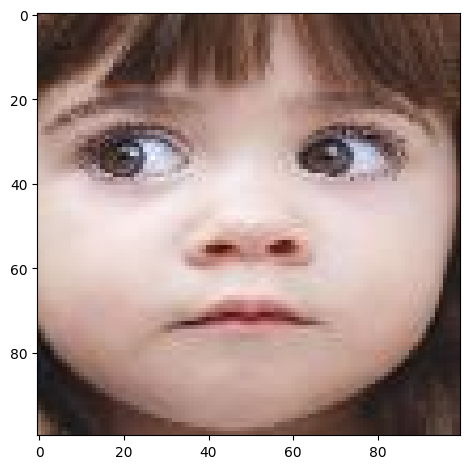

In [5]:
imshow(girl)

/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


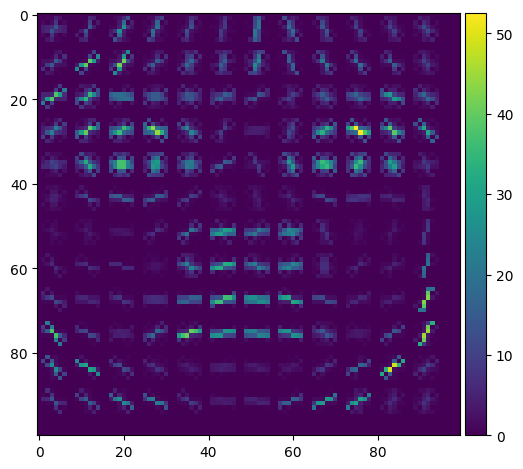

In [6]:
fd, hog_girl = hog(girl, orientations=16, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
imshow(hog_girl)

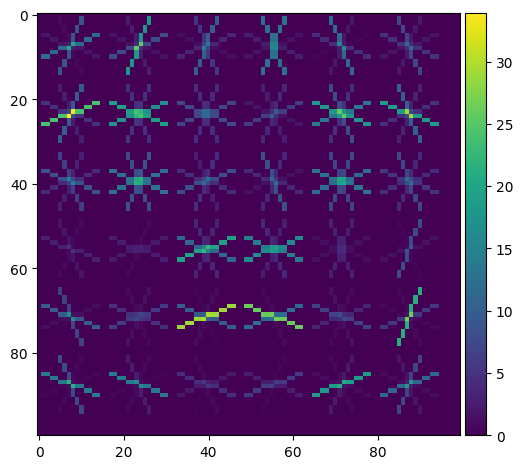

In [7]:
fd, hog_girl = hog(girl, orientations=4, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
imshow(hog_girl)

In [8]:
fd.shape

(400,)

In [9]:
from skimage.feature import canny
from skimage.color import rgb2gray
gray = rgb2gray(girl)
canny_girl1 = canny(gray)
canny_girl2 = canny(gray, sigma=2)

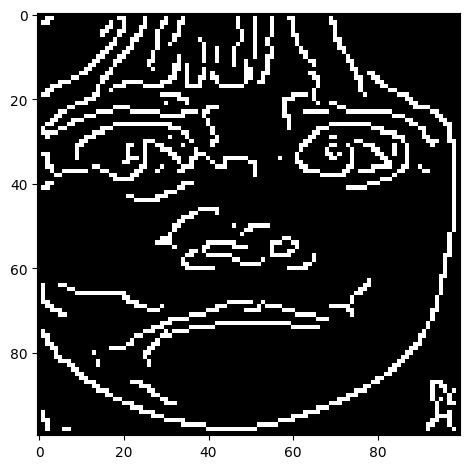

In [10]:
imshow(canny_girl1)

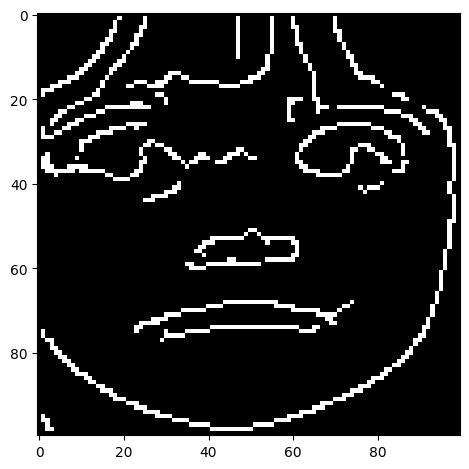

In [11]:
imshow(canny_girl2)

In [12]:
def dataset_by_path(path, convector):
    X = []
    y = []
    i=0

    for class_name in os.listdir(path):
        path_to =path+'/'+class_name
        for img_path in os.listdir(path_to):
            y.append(int(class_name))
            img_arr = convector(imread(path_to+'/'+img_path))
            X.append(img_arr)
    return np.array(X),np.array(y)



In [13]:
hog_conv = lambda x: hog(x, orientations=4, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), channel_axis=-1)

In [14]:
test_f_hog ,test_label =dataset_by_path(test_dir,hog_conv)
train_f_hog ,train_label =dataset_by_path(train_dir,hog_conv)


In [15]:
# canny_conv = lambda x: canny(rgb2gray(x)).flatten()

In [16]:
# test_f_canny ,test_label =dataset_by_path(test_dir,canny_conv)
# train_f_canny ,train_label =dataset_by_path(train_dir,canny_conv)


In [17]:
train_f_hog.shape

(12271, 400)

In [18]:
# train_f_canny.shape

In [19]:
# train_f_canny[0]

# method
# pca 
# model 
# catboost
# svm
# random forest

In [20]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

SEED=42

In [21]:
def data_objectivePCA_RF(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label

    params = {
        "criterion":trial.suggest_categorical("criterion",['gini', 'entropy','log_loss']),
        "n_estimators": trial.suggest_int('n_estimators', 100, 1000, log=True),
        "max_features": trial.suggest_categorical("max_features", ['log2', 'sqrt',None]) ,
        "max_depth": trial.suggest_int("max_depth", 10, 110),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,50),
        "min_samples_leaf": trial.suggest_float("min_samples_leaf", 0.1,0.9)
    }
    pca_param ={
        "n_components": trial.suggest_float("n_components", 0.4, 0.9999),
        'power_iteration_normalizer': trial.suggest_categorical('power_iteration_normalizer',
            ['auto', 'QR', 'LU', 'none']
        ),
        'svd_solver':'full',

    }
    pca = PCA(**pca_param).fit(x,y)
    x = pca.transform(x)
    xt = pca.transform(xt)
            
    clf = RandomForestClassifier(random_state=SEED, **params)
    clf.fit(x, y)
    y_pred = clf.predict(xt)
    acc = accuracy_score(yt, y_pred)
    print(params,pca_param, acc, sep='\n')
    return acc

def data_objective_RF(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label
    params = {
        "criterion":trial.suggest_categorical("criterion",['gini', 'entropy','log_loss']),
        "n_estimators": trial.suggest_int('n_estimators', 100, 1000, log=True),
        "max_features": trial.suggest_categorical("max_features", ['log2', 'sqrt',None]) ,
        "max_depth": trial.suggest_int("max_depth", 10, 110),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,50),
        "min_samples_leaf": trial.suggest_float("min_samples_leaf", 0.1,0.9)
    }
    clf = RandomForestClassifier(random_state=SEED, **params)
    clf.fit(x, y)
    y_pred = clf.predict(xt)
    acc = accuracy_score(yt, y_pred)
    print(params, acc, sep='\n')
    return acc


In [22]:
study = optuna.create_study(direction="maximize")
study.optimize(data_objectivePCA_RF, n_trials=100, timeout=600, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)



{'criterion': 'gini', 'n_estimators': 156, 'max_features': None, 'max_depth': 34, 'min_samples_split': 48, 'min_samples_leaf': 0.2923428608706396}
{'n_components': 0.597363499338699, 'power_iteration_normalizer': 'LU', 'svd_solver': 'full'}
0.4217731421121252
{'criterion': 'log_loss', 'n_estimators': 301, 'max_features': 'log2', 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 0.14229057805865386}
{'n_components': 0.9603282423965419, 'power_iteration_normalizer': 'auto', 'svd_solver': 'full'}
0.386245110821382
{'criterion': 'entropy', 'n_estimators': 177, 'max_features': 'sqrt', 'max_depth': 108, 'min_samples_split': 43, 'min_samples_leaf': 0.705841308307188}
{'n_components': 0.6807790094797689, 'power_iteration_normalizer': 'auto', 'svd_solver': 'full'}
0.386245110821382
{'criterion': 'gini', 'n_estimators': 218, 'max_features': None, 'max_depth': 76, 'min_samples_split': 27, 'min_samples_leaf': 0.539749150767419}
{'n_components': 0.9605120769122435, 'power_iteration_norm

In [23]:
study = optuna.create_study(direction="maximize")
study.optimize(data_objective_RF, n_trials=100, timeout=600, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)

{'criterion': 'log_loss', 'n_estimators': 445, 'max_features': 'sqrt', 'max_depth': 83, 'min_samples_split': 33, 'min_samples_leaf': 0.7508591038630821}
0.386245110821382
{'criterion': 'gini', 'n_estimators': 598, 'max_features': 'log2', 'max_depth': 11, 'min_samples_split': 37, 'min_samples_leaf': 0.6357489798102443}
0.386245110821382
{'criterion': 'entropy', 'n_estimators': 203, 'max_features': None, 'max_depth': 58, 'min_samples_split': 20, 'min_samples_leaf': 0.8244582522071869}
0.386245110821382
{'criterion': 'gini', 'n_estimators': 379, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 48, 'min_samples_leaf': 0.7039273514976011}
0.386245110821382
{'criterion': 'entropy', 'n_estimators': 177, 'max_features': 'log2', 'max_depth': 100, 'min_samples_split': 5, 'min_samples_leaf': 0.28247675293915886}
0.386245110821382
{'criterion': 'entropy', 'n_estimators': 174, 'max_features': 'sqrt', 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 0.3955734222053814}
0.38

In [24]:
def data_objectivePCA_SVC(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label

    params = {
        "C": trial.suggest_float('C', 0.5, 5),
        "decision_function_shape": trial.suggest_categorical("decision_function_shape", ['ovo', 'ovr']) ,
        "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
    }
    if params['kernel'] =='poly':
        params['degree'] = trial.suggest_int('degree',2,10)
        
    pca_param ={
        "n_components": trial.suggest_float("n_components", 0.4, 0.9999),
        'power_iteration_normalizer': trial.suggest_categorical('power_iteration_normalizer',
            ['auto', 'QR', 'LU', 'none']
        ),
        'svd_solver':'full',

    }
    pca = PCA(**pca_param).fit(x,y)
    x = pca.transform(x)
    xt = pca.transform(xt)
            
    clf = SVC(random_state=SEED, **params)
    clf.fit(x, y)
    y_pred = clf.predict(xt)
    acc = accuracy_score(yt, y_pred)
    print(params,pca_param, acc, sep='\n')
    return acc

def data_objective_SVC(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label

    params = {
        "C": trial.suggest_float('C', 0.5, 5),
        "decision_function_shape": trial.suggest_categorical("decision_function_shape", ['ovo', 'ovr']) ,
        "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid', ]),
    }
    if params['kernel'] =='poly':
        params['degree'] = trial.suggest_int('degree',2,10)
        
   
            
    clf = SVC(random_state=SEED, **params)
    clf.fit(x, y)
    y_pred = clf.predict(xt)
    acc = accuracy_score(yt, y_pred)
    print(params, acc, sep='\n')
    return acc

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(data_objectivePCA_SVC, n_trials=200, timeout=1200, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)


{'C': 0.6051353505294343, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
{'n_components': 0.8331593795140775, 'power_iteration_normalizer': 'none', 'svd_solver': 'full'}
0.5889830508474576
{'C': 3.3911866594199465, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
{'n_components': 0.8139147780210845, 'power_iteration_normalizer': 'QR', 'svd_solver': 'full'}
0.6776401564537158
{'C': 3.3634674231076502, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
{'n_components': 0.7509976825834292, 'power_iteration_normalizer': 'auto', 'svd_solver': 'full'}
0.5176010430247718
{'C': 4.814923477230092, 'decision_function_shape': 'ovr', 'kernel': 'sigmoid'}
{'n_components': 0.672214934275027, 'power_iteration_normalizer': 'QR', 'svd_solver': 'full'}
0.5026075619295959
{'C': 1.0843889929634234, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
{'n_components': 0.8056304602888454, 'power_iteration_normalizer': 'QR', 'svd_solver': 'full'}
0.628748370273794
{'C': 3.06187930520158, 'deci

In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(data_objective_SVC, n_trials=200, timeout=1200, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)

{'C': 4.733925159952299, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
0.6466753585397653
{'C': 4.33869450305696, 'decision_function_shape': 'ovr', 'kernel': 'sigmoid'}
0.386245110821382
{'C': 2.071962405111692, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
0.651238591916558
{'C': 3.1465850714439894, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
0.386245110821382
{'C': 3.817389574241683, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
0.386245110821382
{'C': 4.99329493211973, 'decision_function_shape': 'ovr', 'kernel': 'poly', 'degree': 3}
0.6470013037809648
{'C': 1.9283169709214798, 'decision_function_shape': 'ovo', 'kernel': 'poly', 'degree': 5}
0.6587353324641461
{'C': 4.661154814349098, 'decision_function_shape': 'ovr', 'kernel': 'poly', 'degree': 7}
0.666883963494133
{'C': 4.07553156675741, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
0.386245110821382
{'C': 1.7462939088290337, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
0.686766623

In [27]:


def objectivePCA_CAT(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label
    param = {
        "objective": trial.suggest_categorical("objective", ["MultiClass", "MultiClassOneVsAll"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "used_ram_limit": "25gb",
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 4, 200),
        'max_bin': trial.suggest_int('max_bin', 100, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        'random_seed': 42,
        'task_type': 'CPU',
        'eval_metric': 'Accuracy',
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    pca_param ={
        "n_components": trial.suggest_float("n_components", 0.2, 0.9999),
        'power_iteration_normalizer': trial.suggest_categorical('power_iteration_normalizer',
            ['auto', 'QR', 'LU', 'none']
        ),
        'svd_solver':'full',

    }
    
    pca = PCA(**pca_param).fit(x,y)
    x = pca.transform(x)
    xt = pca.transform(xt)
    gbm = CatBoostClassifier(**param)

    gbm.fit(x, y, eval_set=[(xt, yt)], verbose=0, early_stopping_rounds=10)
    preds = gbm.predict(xt)
    pred_labels = np.rint(preds)

    acc = gbm.get_best_score()['validation']['Accuracy']
    print(param,pca_param, acc, sep='\n')
    return acc
def objective_CAT(trial):
    x, xt, y, yt = train_f_hog,test_f_hog,train_label,test_label
    param = {
        "objective": trial.suggest_categorical("objective", ["MultiClass", "MultiClassOneVsAll"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "used_ram_limit": "25gb",
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 4, 200),
        'max_bin': trial.suggest_int('max_bin', 100, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        'random_seed': 42,
        'task_type': 'CPU',
        'eval_metric': 'Accuracy',
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
   
    gbm = CatBoostClassifier(**param)

    gbm.fit(x, y, eval_set=[(xt, yt)], verbose=0, early_stopping_rounds=10)
    preds = gbm.predict(xt)
    pred_labels = np.rint(preds)

    acc = gbm.get_best_score()['validation']['Accuracy']
    print(param, acc, sep='\n')
    return acc

In [28]:
study = optuna.create_study(direction="maximize")
study.optimize(objectivePCA_CAT, n_trials=100, timeout=1200, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)



{'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.07064233793395717, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'used_ram_limit': '25gb', 'max_depth': 7, 'learning_rate': 0.02, 'n_estimators': 65, 'max_bin': 301, 'min_data_in_leaf': 19, 'l2_leaf_reg': 0.0008017396899347462, 'random_seed': 42, 'task_type': 'CPU', 'eval_metric': 'Accuracy', 'bagging_temperature': 6.731305201306583}
{'n_components': 0.8561656908340431, 'power_iteration_normalizer': 'auto', 'svd_solver': 'full'}
0.45078226857887876
{'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.04287596891986313, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'used_ram_limit': '25gb', 'max_depth': 12, 'learning_rate': 0.05, 'n_estimators': 184, 'max_bin': 172, 'min_data_in_leaf': 109, 'l2_leaf_reg': 0.002243358090094651, 'random_seed': 42, 'task_type': 'CPU', 'eval_metric': 'Accuracy', 'subsample': 0.16829202550491845}
{'n_components': 0.8593636530748361, 'power_iteration_normalizer': 'LU', 'sv

In [29]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_CAT, n_trials=100, timeout=1200, n_jobs=2)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
print("  Value: {}".format(trial.value))
print(trial.params)

{'objective': 'MultiClass', 'colsample_bylevel': 0.07003321244640665, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'used_ram_limit': '25gb', 'max_depth': 3, 'learning_rate': 0.08, 'n_estimators': 27, 'max_bin': 294, 'min_data_in_leaf': 5, 'l2_leaf_reg': 0.23531850222675835, 'random_seed': 42, 'task_type': 'CPU', 'eval_metric': 'Accuracy', 'bagging_temperature': 5.915677983048412}
0.4579530638852673
{'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.06309276878582645, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'used_ram_limit': '25gb', 'max_depth': 3, 'learning_rate': 0.08, 'n_estimators': 123, 'max_bin': 288, 'min_data_in_leaf': 188, 'l2_leaf_reg': 0.017939140582898916, 'random_seed': 42, 'task_type': 'CPU', 'eval_metric': 'Accuracy', 'bagging_temperature': 1.7432458609063606}
0.5752933507170795
{'objective': 'MultiClass', 'colsample_bylevel': 0.04204990676230858, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'used_ram_limit': '25gb', 'max_de